In [1]:
!pip install -q datasets transformers accelerate bitsandbytes peft trl torch
!pip install -q matplotlib seaborn pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 28.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 423.1/423.1 kB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 65.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 80.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 67.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 28.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import gc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    TrainingArguments,
    BitsAndBytesConfig
)
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
from trl import SFTTrainer
import torch

2025-11-02 02:17:25.982219: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762049846.172871      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762049846.230126      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `ty

In [3]:
gc.collect()
torch.cuda.empty_cache()

print("🚀 Nemotron-Personas-India Training (Memory Optimized)")

🚀 Nemotron-Personas-India Training (Memory Optimized)


In [9]:
print("\n" + "="*80)
print("📥 Loading Dataset")
print("="*80)

# Choose language: 'en_IN', 'hi_Deva_IN', 'hi_Latn_IN'
LANGUAGE = "en_IN"  # English India
SAMPLE_SIZE = 5000  # Use subset to save memory

print(f"Loading {LANGUAGE} split...")
# The language name IS the split (no separate "train" split)
dataset = load_dataset("nvidia/Nemotron-Personas-India", split=LANGUAGE)

# Take a small sample for training (adjust based on your memory)
dataset = dataset.shuffle(seed=42).select(range(SAMPLE_SIZE))
print(f"✅ Using {len(dataset)} samples")

print(f"\n📋 Available fields:")
for key in dataset.features.keys():
    print(f"  - {key}")

print(f"\n🔍 Sample record:")
sample = dataset[0]
print(f"UUID: {sample['uuid'][:32]}...")
print(f"Professional Persona: {sample['professional_persona'][:200]}...")
print(f"Age: {sample['age']}, Sex: {sample['sex']}, State: {sample['state']}")


📥 Loading Dataset
Loading en_IN split...


Resolving data files:   0%|          | 0/26 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/26 [00:00<?, ?it/s]

✅ Using 5000 samples

📋 Available fields:
  - uuid
  - professional_persona
  - linguistic_persona
  - sports_persona
  - arts_persona
  - travel_persona
  - culinary_persona
  - persona
  - cultural_background
  - linguistic_background
  - skills_and_expertise
  - skills_and_expertise_list
  - hobbies_and_interests
  - hobbies_and_interests_list
  - career_goals_and_ambitions
  - sex
  - age
  - marital_status
  - education_level
  - education_degree
  - occupation
  - first_language
  - second_language
  - third_language
  - zone
  - state
  - district
  - country

🔍 Sample record:
UUID: 42d7020481344ff38be0cc041606fb1c...
Professional Persona: Kalabati Khadshidas is a seasoned homemaker and budding cottage entrepreneur who skillfully prepares traditional sweets, coordinates community festivals, and applies meticulous budgeting, while their ...
Age: 38, Sex: Female, State: West Bengal



📊 Quick Data Analysis

📈 Demographics:
Age range: 18 - 103
Sex distribution:
sex
Female    502
Male      498
Name: count, dtype: int64
Top 5 states:
state
Uttar Pradesh    142
Maharashtra      104
West Bengal       74
Tamil Nadu        74
Bihar             71
Name: count, dtype: int64
Top 5 occupations:
occupation
No Occupation / Retired / Homemaker                 391
Market-Oriented Crop and Animal Producers, Other     13
Shop Attendant                                       10
Well Digger Helper                                   10
Building Construction Labourers, Other               10
Name: count, dtype: int64


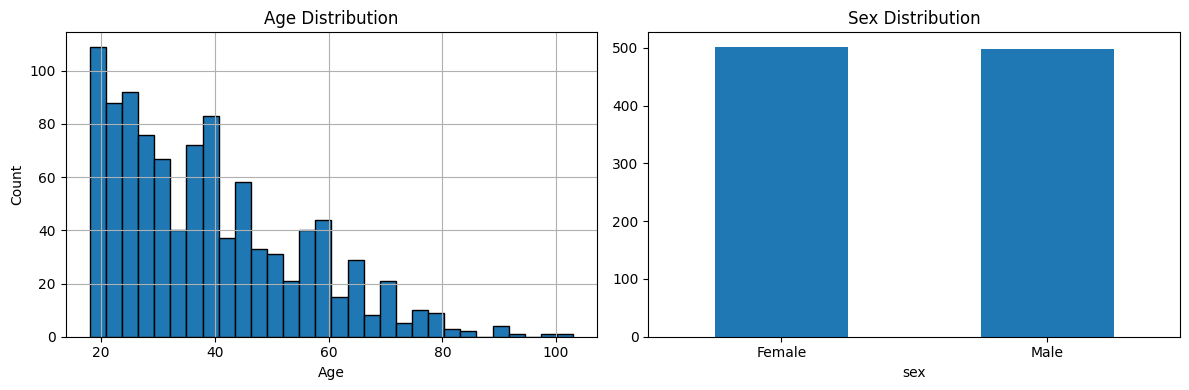

✅ Saved: demographics.png


In [10]:
print("\n" + "="*80)
print("📊 Quick Data Analysis")
print("="*80)

# Convert 1000 samples to pandas for quick stats
df_sample = pd.DataFrame(dataset.select(range(min(1000, len(dataset)))))

print(f"\n📈 Demographics:")
print(f"Age range: {df_sample['age'].min()} - {df_sample['age'].max()}")
print(f"Sex distribution:\n{df_sample['sex'].value_counts()}")
print(f"Top 5 states:\n{df_sample['state'].value_counts().head()}")
print(f"Top 5 occupations:\n{df_sample['occupation'].value_counts().head()}")

# Plot age distribution
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
df_sample['age'].hist(bins=30, edgecolor='black')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
df_sample['sex'].value_counts().plot(kind='bar')
plt.title('Sex Distribution')
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('demographics.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ Saved: demographics.png")

In [11]:
del df_sample
gc.collect()

7607

In [12]:
print("\n" + "="*80)
print("🔧 Formatting Dataset")
print("="*80)



🔧 Formatting Dataset


In [13]:
def format_persona(example):
    """
    Format persona data into instruction-response pairs
    
    Dataset has rich persona fields:
    - professional_persona, linguistic_persona, sports_persona, etc.
    - persona (summary), cultural_background, skills, hobbies
    - demographics: age, sex, occupation, state, etc.
    """
    
    # Create instruction asking about the person
    instruction = f"Describe a person from {example['state']}, India who is a {example['age']}-year-old {example['sex'].lower()} working as {example['occupation']}."
    
    # Combine relevant persona fields as response
    response_parts = []
    
    if example['persona']:
        response_parts.append(example['persona'])
    
    if example['professional_persona']:
        response_parts.append(f"Professionally: {example['professional_persona']}")
    
    if example['cultural_background']:
        response_parts.append(f"Cultural background: {example['cultural_background']}")
    
    if example['hobbies_and_interests']:
        response_parts.append(f"Hobbies: {example['hobbies_and_interests']}")
    
    response = "\n\n".join(response_parts)
    
    # Format as instruction-response
    text = f"""### Instruction:
{instruction}

### Response:
{response}"""
    
    return {"text": text}

# Apply formatting
formatted_dataset = dataset.map(
    format_persona,
    remove_columns=dataset.column_names,
    desc="Formatting personas"
)

print(f"✅ Formatted {len(formatted_dataset)} examples")
print("\n📄 Sample formatted:")
print("-"*80)
print(formatted_dataset[0]['text'][:600])
print("...")
print("-"*80)

# Train/test split
split = formatted_dataset.train_test_split(test_size=0.1, seed=42)
train_data = split['train']
eval_data = split['test']
print(f"\n✅ Train: {len(train_data)} | Eval: {len(eval_data)}")

Formatting personas:   0%|          | 0/5000 [00:00<?, ? examples/s]

✅ Formatted 5000 examples

📄 Sample formatted:
--------------------------------------------------------------------------------
### Instruction:
Describe a person from West Bengal, India who is a 38-year-old female working as No Occupation / Retired / Homemaker.

### Response:
Kalabati Khadshidas weaves sweet memories into meticulous alpona art while juggling family finances, yet their ever-present worry often fuels a careful, slightly anxious yet warmly creative life.

Professionally: Kalabati Khadshidas is a seasoned homemaker and budding cottage entrepreneur who skillfully prepares traditional sweets, coordinates community festivals, and applies meticulous budgeting, while their practical curiosity drives them to ex
...
--------------------------------------------------------------------------------

✅ Train: 4500 | Eval: 500


In [14]:
print("\n" + "="*80)
print("🤖 Loading Model (4-bit Quantized)")
print("="*80)

# Use small model for limited memory
MODEL_NAME = "microsoft/phi-2"  # 2.7B params, fits in 15GB GPU
# Alternatives: "TinyLlama/TinyLlama-1.1B-Chat-v1.0" (1.1B)

print(f"📦 Model: {MODEL_NAME}")

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
)

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True,
    torch_dtype=torch.float16
)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

print("✅ Model loaded")

# Prepare for training
model = prepare_model_for_kbit_training(model)

lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["q_proj", "k_proj", "v_proj", "dense"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, lora_config)

trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
total = sum(p.numel() for p in model.parameters())
print(f"📊 Trainable: {trainable:,} / {total:,} ({100*trainable/total:.2f}%)")



🤖 Loading Model (4-bit Quantized)
📦 Model: microsoft/phi-2


config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/564M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

✅ Model loaded
📊 Trainable: 5,242,880 / 1,526,635,520 (0.34%)


In [21]:
print("\n" + "="*80)
print("🏋️ Training")
print("="*80)

OUTPUT_DIR = "./nemotron-personas-finetuned"

training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    num_train_epochs=1,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=8,
    gradient_checkpointing=True,
    learning_rate=2e-4,
    warmup_steps=50,
    logging_steps=50,
    save_steps=500,
    eval_steps=500,
    eval_strategy="steps",  # Changed from evaluation_strategy
    save_strategy="steps",
    save_total_limit=2,
    load_best_model_at_end=True,
    fp16=True,
    optim="paged_adamw_8bit",
    max_grad_norm=0.3,
    report_to="none",
    dataloader_pin_memory=False,
)

# Use standard Trainer instead of SFTTrainer (API changed too much)
from transformers import Trainer, DataCollatorForLanguageModeling

# Data collator for causal language modeling
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False  # We're doing causal LM, not masked LM
)

# Tokenize the dataset
def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        truncation=True,
        max_length=512,
        padding="max_length"
    )

print("Tokenizing datasets...")
tokenized_train = train_data.map(tokenize_function, batched=True, remove_columns=["text"])
tokenized_eval = eval_data.map(tokenize_function, batched=True, remove_columns=["text"])

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_eval,
    data_collator=data_collator,
)

print("\n🚀 Starting training...\n")
trainer.train()

print("\n✅ Training complete!")
trainer.save_model(OUTPUT_DIR)
tokenizer.save_pretrained(OUTPUT_DIR)
print(f"💾 Model saved to: {OUTPUT_DIR}")


🏋️ Training
Tokenizing datasets...


Map:   0%|          | 0/4500 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.



🚀 Starting training...



Step,Training Loss,Validation Loss
500,1.440600,1.398604



✅ Training complete!
💾 Model saved to: ./nemotron-personas-finetuned



📈 Training Metrics


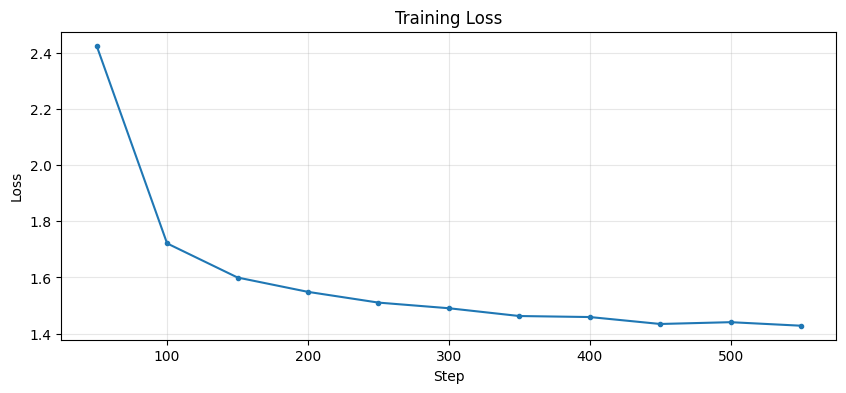

✅ Saved: training_loss.png


In [22]:
print("\n" + "="*80)
print("📈 Training Metrics")
print("="*80)

history = trainer.state.log_history
train_loss = [log['loss'] for log in history if 'loss' in log]
steps = [log['step'] for log in history if 'loss' in log]

if train_loss:
    plt.figure(figsize=(10, 4))
    plt.plot(steps, train_loss, marker='o', markersize=3)
    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.grid(alpha=0.3)
    plt.savefig('training_loss.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("✅ Saved: training_loss.png")

In [23]:
print("\n" + "="*80)
print("🧪 Testing Model")
print("="*80)

def generate(prompt, max_tokens=256):
    """Generate persona description"""
    formatted = f"### Instruction:\n{prompt}\n\n### Response:\n"
    inputs = tokenizer(formatted, return_tensors="pt").to(model.device)
    
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_tokens,
            temperature=0.7,
            top_p=0.9,
            do_sample=True,
            pad_token_id=tokenizer.pad_token_id
        )
    
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return response.split("### Response:")[-1].strip()

# Test with persona-style prompts
test_prompts = [
    "Describe a 35-year-old teacher from Delhi who loves cricket.",
    "Tell me about a software engineer from Bangalore aged 28.",
    "Describe a farmer from rural Punjab who is 50 years old."
]

for i, prompt in enumerate(test_prompts, 1):
    print(f"\n{'='*80}")
    print(f"Test {i}: {prompt}")
    print('-'*80)
    response = generate(prompt)
    print(f"Response:\n{response}")



🧪 Testing Model

Test 1: Describe a 35-year-old teacher from Delhi who loves cricket.
--------------------------------------------------------------------------------
Response:
Ravindra Kumar is a 35‑year‑old cricket fanatic who blends meticulous planning with spontaneous improvisation, balances a love for teaching with a passion for cricket, and finds solace in solitary nights of strategy and quiet reflection.

Professionally: Ravindra Kumar is a 35‑year‑old mathematics and physics teacher who blends structured lesson plans with creative problem‑solving, and they leverage their competitive cricket spirit to motivate students, while also nurturing a curiosity‑driven approach to curriculum design.

Cultural background: Ravindra Kumar comes from a middle‑class Hindu family in North‑West Delhi. He grew up in a traditional joint‑family setting, where cultural practices like Diwali, Holi and Navratri are celebrated with great enthusiasm. The city’s diverse culinary scene, the prevalence of

In [24]:
print("💾 Memory Usage")
print("="*80)

if torch.cuda.is_available():
    print(f"GPU Allocated: {torch.cuda.memory_allocated()/1e9:.2f} GB")
    print(f"GPU Reserved: {torch.cuda.memory_reserved()/1e9:.2f} GB")

print("\n✅ DONE!")
print(f"Model saved in: {OUTPUT_DIR}")
print("\nDataset info:")
print(f"- 3M Indian personas with 27 demographic/cultural fields")
print(f"- Languages: English (en_IN), Hindi Devanagari (hi_Deva_IN), Hindi Latin (hi_Latn_IN)")
print(f"- Fields: persona, professional_persona, cultural_background, hobbies, etc.")
print(f"- Demographics: age, sex, state, occupation, education, etc.")

💾 Memory Usage
GPU Allocated: 0.96 GB
GPU Reserved: 1.50 GB

✅ DONE!
Model saved in: ./nemotron-personas-finetuned

Dataset info:
- 3M Indian personas with 27 demographic/cultural fields
- Languages: English (en_IN), Hindi Devanagari (hi_Deva_IN), Hindi Latin (hi_Latn_IN)
- Fields: persona, professional_persona, cultural_background, hobbies, etc.
- Demographics: age, sex, state, occupation, education, etc.
